In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from wanna_buy_house.data import final_treatment
from wanna_buy_house.utils import final_transformer

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [3]:
data_cleaned = final_treatment()
data = final_transformer(data_cleaned)
data

get_data 0.15


,Loan.Status,Credit.Minus.Loan,Years.current_job_enc,Tax.Liens.Enc,Leverage,Bankruptcies.enc,Years.since.last.delinquent,Loan.vs.Income,Term.Encoded,Number.of.Open.Accounts.Labeled,...,H.O.Home Mortgage,H.O.Own Home,H.O.Rent,Purp.Business Loan,Purp.Buy House,Purp.Buy a Car,Purp.Debt Consolidation,Purp.Home Improvements,Purp.Medical Bills,Purp.Other
0,1,1,6,0,0.190000,0,1,0.187495,0.0,2,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1,4,0,0.301998,1,0,0.207542,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,10,0,0.085501,0,0,0.075625,0.0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1,0,5,0,0.127000,1,0,0.165112,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0,0,10,0,0.056798,0,0,0.075445,1.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60794,1,0,6,0,0.047101,0,0,0.119199,0.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60795,1,1,1,0,0.197000,0,0,0.100010,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60797,1,1,10,0,0.292000,0,0,0.279996,1.0,2,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60800,0,0,3,0,0.103000,0,1,0.200004,0.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
#Converted Year.Credit.History.Labeled from category to int64
data['Year.Credit.History.Labeled'] = data['Year.Credit.History.Labeled'].astype('int64')

# FEATURE SELECTION - tirando purpose of loan e outras variaveis 
# NOVO GRIDSEARCH

In [5]:
# Defining variables considering results of feature selection
X = data.drop(columns=['Loan.Status', 'Tax.Liens.Enc',
                      'Bankruptcies.enc', 'Number.of.Open.Accounts.Labeled', 'Purp.Buy a Car',
                      'Purp.Buy House', 'Purp.Medical Bills', 'Purp.Business Loan',
                      'Purp.Home Improvements', 'Purp.Debt Consolidation','Purp.Other',
                       'H.O.Own Home', 'H.O.Rent', 'H.O.Home Mortgage'])
y = data['Loan.Status'] 
# Train Test Split both datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# GERACAO DE DADOS ARTIFICIAIS PARA A CATEGORIA DO TARGET MINORITARIO 0 A PARTIR DOS DADOS EXISTENTES
sm = SMOTE()
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

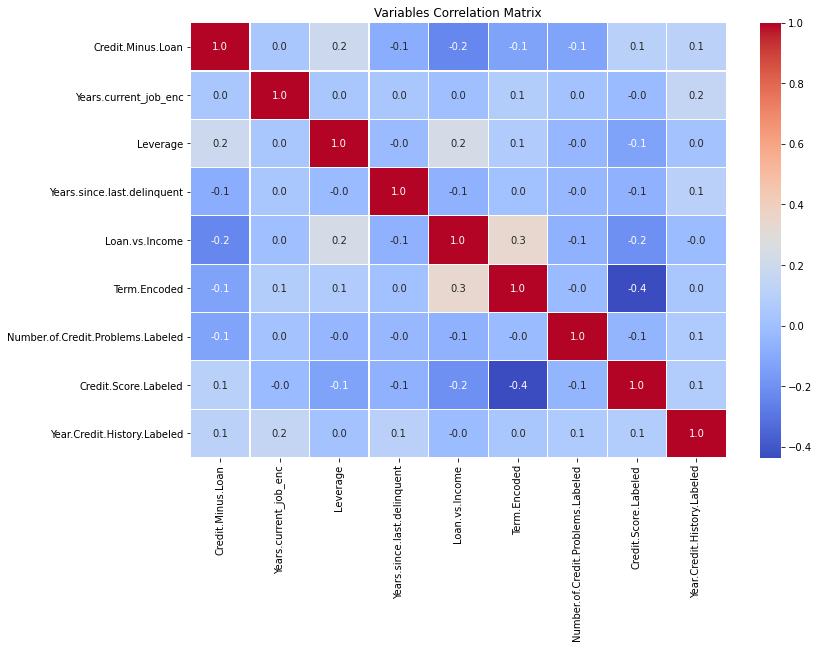

In [6]:
# Correlation matrix of features selected --> little multicollinearity
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), cmap='coolwarm', annot=True, fmt='.1f', linewidths=.1)
plt.title("Variables Correlation Matrix")
plt.show()

In [7]:
#Applied GridSearchCV (rs)
forest_rs = RandomForestClassifier(n_jobs=-1,
                                   max_features='log2',
                                   n_estimators=1950,
                                   max_depth=32,
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   random_state=13)

# Model fit, score and score metrics
forest_rs.fit(X_train_bal, y_train_bal)
forest_rs.score(X_test, y_test)
y_pred_forest_rs = forest_rs.predict(X_test)
cv_forest_rs = cross_validate(forest_rs,
                          X_train_bal,
                          y_train_bal,
                          scoring='f1_weighted',
                          cv=10)
print('RANDOM FOREST W/ FEATURE SELECTION & GRID SEARCH - CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred_forest_rs))

RANDOM FOREST W/ FEATURE SELECTION & GRID SEARCH - CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.35      0.39      0.37      3373
           1       0.76      0.72      0.74      8980

    accuracy                           0.63     12353
   macro avg       0.55      0.56      0.55     12353
weighted avg       0.65      0.63      0.64     12353



In [8]:
#Feature selection using permutation importance

perm_score = permutation_importance(forest_rs, X_train_bal, y_train_bal, random_state=42, n_repeats=1)
perm_score['importances_mean']
df = pd.DataFrame({'features': X.columns, 'importance_mean': perm_score['importances_mean']}).sort_values('importance_mean')

In [9]:
df

,features,importance_mean
6,Number.of.Credit.Problems.Labeled,0.052014
3,Years.since.last.delinquent,0.104075
0,Credit.Minus.Loan,0.131903
8,Year.Credit.History.Labeled,0.171253
5,Term.Encoded,0.178180
7,Credit.Score.Labeled,0.216435
1,Years.current_job_enc,0.253023
2,Leverage,0.342816
4,Loan.vs.Income,0.369215


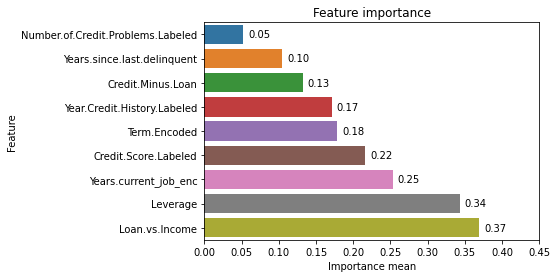

In [10]:
ax=sns.barplot(x='importance_mean', y='features', data=df)
ax.set(title='Feature importance')
ax.set_xlim(0, 0.45)
ax.set(xlabel='Importance mean', ylabel='Feature')

for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.show()

In [11]:
#GridSearch for random forest model

param_grid = {'n_estimators': [1950],
              'max_features': ['log2'],
              'max_depth': [32],
              'min_samples_split': [2],
              'min_samples_leaf': [1],
              'random_state': [13]
}

CV_forest_rs = GridSearchCV(forest_rs, 
                            param_grid,
                            scoring='f1_weighted', 
                            cv=3, verbose=1, n_jobs=-1)
CV_forest_rs.fit(X_train_bal, y_train_bal)
print(CV_forest_rs.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


{'max_depth': 32, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1950, 'random_state': 13}


No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.607


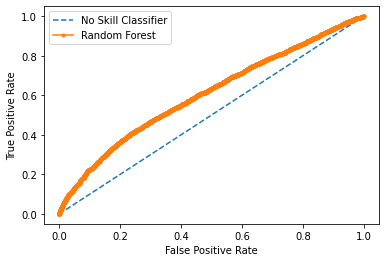

In [12]:
#It returns the AUC score between 0.0 and 1.0 for no skill and perfect skill respectively.
# ROC AUC for Random Forest with RandomSearch
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = forest_rs.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Classifier')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [13]:
y_pred_proba1_forest_rs = np.delete(forest_rs.predict_proba(X_test), 0, 1)

c:\users\m_day\.venvs\lewagon\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


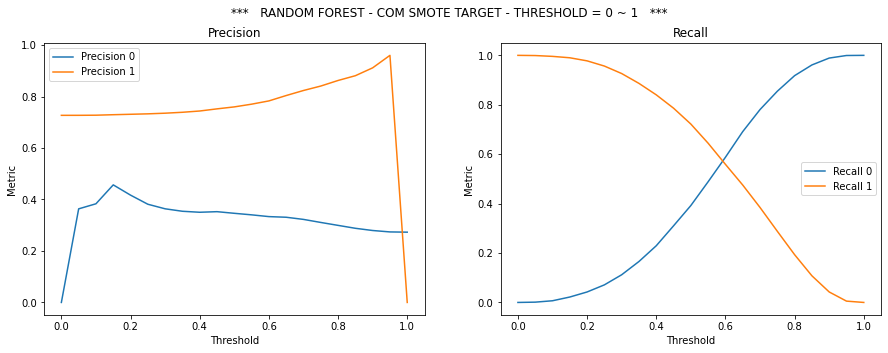

In [14]:
thresholds = np.arange(0.0, 1.05, 0.05)
metrics_per_threshold_forest_rs = []
for threshold in thresholds:
    y_pred_adj_forest_rs = y_pred_proba1_forest_rs.copy()
    for row in range(len(y_pred_adj_forest_rs)):
        if y_pred_adj_forest_rs[row] >= threshold:
            y_pred_adj_forest_rs[row] = 1
        else:
            y_pred_adj_forest_rs[row] = 0
    precision_0 = classification_report(y_true=y_test, y_pred=y_pred_adj_forest_rs, output_dict=True)['0']['precision']
    precision_1 = classification_report(y_true=y_test, y_pred=y_pred_adj_forest_rs, output_dict=True)['1']['precision']
    recall_0 = classification_report(y_true=y_test, y_pred=y_pred_adj_forest_rs, output_dict=True)['0']['recall']
    recall_1 = classification_report(y_true=y_test, y_pred=y_pred_adj_forest_rs, output_dict=True)['1']['recall']
    metrics_per_threshold_forest_rs.append([threshold, precision_0, precision_1, recall_0, recall_1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('***   RANDOM FOREST - COM SMOTE TARGET - THRESHOLD = 0 ~ 1   ***')
ax1.plot(np.array(metrics_per_threshold_forest_rs)[:,0], np.array(metrics_per_threshold_forest_rs)[:,1])
ax1.plot(np.array(metrics_per_threshold_forest_rs)[:,0], np.array(metrics_per_threshold_forest_rs)[:,2])
ax1.legend(['Precision 0', 'Precision 1'], loc='best')
ax1.set_ylabel('Metric')
ax1.set_xlabel('Threshold')
ax1.set_title('Precision')
ax2.plot(np.array(metrics_per_threshold_forest_rs)[:,0], np.array(metrics_per_threshold_forest_rs)[:,3])
ax2.plot(np.array(metrics_per_threshold_forest_rs)[:,0], np.array(metrics_per_threshold_forest_rs)[:,4])
ax2.legend(['Recall 0', 'Recall 1'], loc='best')
ax2.set_ylabel('Metric')
ax2.set_xlabel('Threshold')
ax2.set_title('Recall')
plt.show()

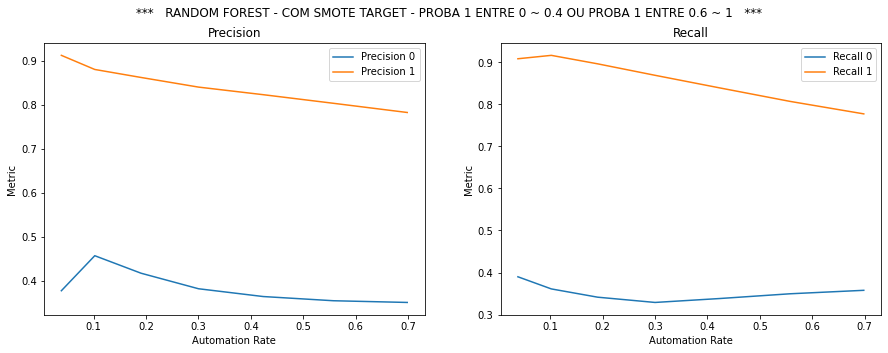

In [15]:
proba1_min_lst = np.arange(0.1, 0.45, 0.05)
proba1_max_lst = np.flip(np.arange(0.6, 0.95, 0.05))
metrics_per_threshold_forest_rs = []
for proba1_min, proba1_max in zip(proba1_min_lst, proba1_max_lst):
    y_test_proba1_min_max = y_test.copy()
    y_test_proba1_min_max = pd.DataFrame(y_test_proba1_min_max)
    y_test_proba1_min_max['y_pred_proba1_forest_rs'] = y_pred_proba1_forest_rs
    y_test_proba1_min_max = y_test_proba1_min_max.loc[(y_test_proba1_min_max['y_pred_proba1_forest_rs'] <= proba1_min) |
                                                      (y_test_proba1_min_max['y_pred_proba1_forest_rs'] >= proba1_max)]
    y_test_proba1_min_max = y_test_proba1_min_max.drop(columns='y_pred_proba1_forest_rs')
    y_pred_forest_rs_proba1_min_max = pd.DataFrame(y_pred_forest_rs)
    y_pred_forest_rs_proba1_min_max['y_pred_proba1_forest_rs'] = y_pred_proba1_forest_rs
    y_pred_forest_rs_proba1_min_max = y_pred_forest_rs_proba1_min_max.loc[(y_pred_forest_rs_proba1_min_max['y_pred_proba1_forest_rs'] <= proba1_min) |
                                                                          (y_pred_forest_rs_proba1_min_max['y_pred_proba1_forest_rs'] >= proba1_max)]
    y_pred_forest_rs_proba1_min_max = y_pred_forest_rs_proba1_min_max.drop(columns='y_pred_proba1_forest_rs')
    precision_0 = classification_report(y_true=y_test_proba1_min_max, y_pred=y_pred_forest_rs_proba1_min_max, output_dict=True)['0']['precision']
    precision_1 = classification_report(y_true=y_test_proba1_min_max, y_pred=y_pred_forest_rs_proba1_min_max, output_dict=True)['1']['precision']
    recall_0 = classification_report(y_true=y_test_proba1_min_max, y_pred=y_pred_forest_rs_proba1_min_max, output_dict=True)['0']['recall']
    recall_1 = classification_report(y_true=y_test_proba1_min_max, y_pred=y_pred_forest_rs_proba1_min_max, output_dict=True)['1']['recall']
    auto_rate = len(y_pred_forest_rs_proba1_min_max) / len(y_test)
    metrics_per_threshold_forest_rs.append([proba1_min, proba1_max, auto_rate, precision_0, precision_1, recall_0, recall_1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('***   RANDOM FOREST - COM SMOTE TARGET - PROBA 1 ENTRE 0 ~ 0.4 OU PROBA 1 ENTRE 0.6 ~ 1   ***')
ax1.plot(np.array(metrics_per_threshold_forest_rs)[:,2], np.array(metrics_per_threshold_forest_rs)[:,3])
ax1.plot(np.array(metrics_per_threshold_forest_rs)[:,2], np.array(metrics_per_threshold_forest_rs)[:,4])
ax1.legend(['Precision 0', 'Precision 1'], loc='best')
ax1.set_ylabel('Metric')
ax1.set_xlabel('Automation Rate')
ax1.set_title('Precision')
ax2.plot(np.array(metrics_per_threshold_forest_rs)[:,2], np.array(metrics_per_threshold_forest_rs)[:,5])
ax2.plot(np.array(metrics_per_threshold_forest_rs)[:,2], np.array(metrics_per_threshold_forest_rs)[:,6])
ax2.legend(['Recall 0', 'Recall 1'], loc='best')
ax2.set_ylabel('Metric')
ax2.set_xlabel('Automation Rate')
ax2.set_title('Recall')
plt.show()

## Confusion matrix

In [16]:
confusion_matrix(y_test, y_pred_forest_rs)

array([[1323, 2050],
       [2501, 6479]], dtype=int64)

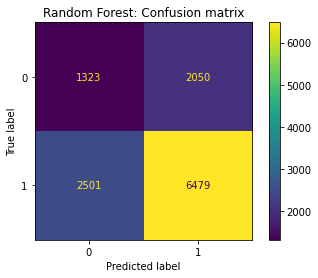

In [17]:
plot_confusion_matrix(forest_rs, X_test, y_test)
plt.title('Random Forest: Confusion matrix')
plt.show()

In [18]:
y_pred_probas_0, y_pred_probas_1 = cross_val_predict(forest_rs,
                                                     X_train_bal, y_train_bal,
                                                     method = "predict_proba").T

In [19]:
forest_rs.fit(X_train_bal, y_train_bal)

RandomForestClassifier(max_depth=32, max_features='log2', n_estimators=1950,
                       n_jobs=-1, random_state=13)

In [20]:
y_pred_probas_0, y_pred_probas_1 = forest_rs.predict_proba(X_test).T

In [37]:
y_pred=1-(y_pred_probas_0>1-threshold0).astype(int)
print(classification_report(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [12353, 42008]

In [38]:
len(y_pred_probas_1[y_pred_probas_1>threshold1])*0.2

2491.2000000000003

In [39]:
len(y_pred_probas_0[y_pred_probas_0>1-threshold0])*0.63

5688.27

In [40]:
len(y_pred_probas_1[y_pred_probas_1<threshold1])

29551

In [41]:
len(y_pred_probas_1[y_pred_probas_1<threshold0])

9029

## Threshold adjustment

In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_pred_probas_0, y_pred_probas_1 = cross_val_predict(forest_rs,
                                                     X_train_bal, y_train_bal,
                                                     method = "predict_proba").T

In [36]:
y_pred=(y_pred_probas_0>threshold0).astype(int)
print(classification_report(y_train_bal, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.05      0.08     21004
           1       0.42      0.70      0.53     21004

    accuracy                           0.38     42008
   macro avg       0.29      0.38      0.30     42008
weighted avg       0.29      0.38      0.30     42008



In [31]:
pd.DataFrame(y_pred_probas_1).count()

0    42008
dtype: int64

0.6280338630816084

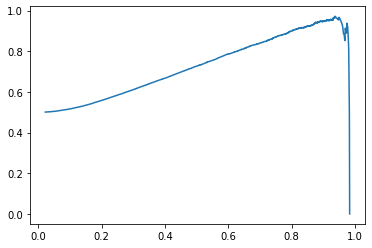

In [30]:
# Generate precision and thresholds (and recalls) using probabilities for class 1
precision, recall, thresholds = precision_recall_curve(y_train_bal, y_pred_probas_1)

# Populate dataframe with precision and threshold
df_precision1 = pd.DataFrame({"precision" : precision[:-1], "threshold" : thresholds})
plt.plot(df_precision1['threshold'],df_precision1['precision'])

# Classe 1: Find out which threshold guarantees a precision of 0.8
threshold1 = df_precision1[df_precision1['precision'] >= 0.8]['threshold'].min()
threshold1

In [32]:
df_precision1.head()

,precision,threshold
0,0.500727,0.022051
1,0.500739,0.022217
2,0.500751,0.022270
3,0.500763,0.022564
4,0.500775,0.022624


In [33]:
df_precision1[df_precision1['threshold'] > threshold1].count()

precision    7354
threshold    7354
dtype: int64

0.2764102564102564

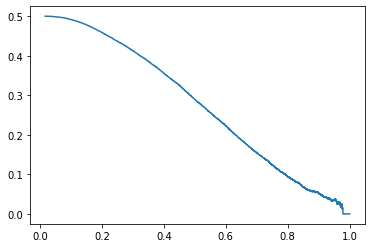

In [34]:
# Generate precision and thresholds (and recalls) using probabilities for class 0
precision, recall, thresholds = precision_recall_curve(y_train_bal, y_pred_probas_0)

# Populate dataframe with precision and threshold
df_precision0 = pd.DataFrame({"precision" : precision[:-1], "threshold" : thresholds})
plt.plot(df_precision0['threshold'],df_precision0['precision'])

# Classe 0: Find out which threshold guarantees a precision of 0.425
threshold0 = df_precision0[df_precision0['precision'] >= 0.425]['threshold'].max()
threshold0

In [35]:
df_precision0[df_precision0['threshold'] < threshold0].count()

precision    4163
threshold    4163
dtype: int64

## Para uma solicitacao qualquer, a sequencia seria:

### Scale using original scaler
new_player_scaled = scaler.transform(new_player)

### Train a Logistic Regression model on the preprocessed dataset
log_model = LogisticRegression()
log_model.fit(X_scaled, data['target_5y'])

### Predict probabilities of new player belonging to each class
probas = log_model.predict_proba(new_player_scaled)

### Will the new player last at least 5 years as a pro?
probas[0][1] > threshold